<a href="https://colab.research.google.com/github/divyanshuraj6815/EVA6/blob/main/Experiment_5/experiment_5_code_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target
- Increase the capacity of the model
- Introduce LeakyReLU and Batch Normalization after each layer
- Reduce Learning Rate after every 6 epochs


# Result
- Parameters : `8,858`
- Best Train Accuracy : `99.96`
- Best Test Accuracy : `99.21` 


# Analysis
- Test Accuracy `99.1` is consistent over last few epochs.
- Model is clearly over-fitting
- Dropout is required
- Observing the wrongly classified images, we can introduce a slight rotation in data augmentation

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.LeakyReLU (),
            nn.BatchNorm2d(16),
        ) # output_size = 26

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 13

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.LeakyReLU (),            
            nn.BatchNorm2d(16),
        ) # output_size = 11

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.LeakyReLU (),            
            nn.BatchNorm2d(16),
        ) # output_size = 9

        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 5

        self.convblock4 = nn.Sequential(
            nn.Linear (400,10),
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool1(x)
        x = self.convblock2(x)
        x = self.pool2(x)
        x = self.convblock3(x)
        x = x.view(-1, 400)
        x = self.convblock4(x)

        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
         LeakyReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
         MaxPool2d-4           [-1, 16, 13, 13]               0
            Conv2d-5           [-1, 16, 11, 11]           2,304
         LeakyReLU-6           [-1, 16, 11, 11]               0
       BatchNorm2d-7           [-1, 16, 11, 11]              32
         MaxPool2d-8             [-1, 16, 5, 5]               0
            Conv2d-9             [-1, 16, 5, 5]           2,304
        LeakyReLU-10             [-1, 16, 5, 5]               0
      BatchNorm2d-11             [-1, 16, 5, 5]              32
           Linear-12                   [-1, 10]           4,010
Total params: 8,858
Trainable params: 8,858
Non-trainable params: 0
------------------------------

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    #scheduler.step ()
    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return 100. * correct / len(test_loader.dataset)

# Let's Train and test our model

This time let's add a scheduler for out LR. 

In [9]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.3)

EPOCHS = 25
count = 0

for epoch in range(EPOCHS):
    print("EPOCH:", epoch, scheduler.get_lr ())
    train(model, device, train_loader, optimizer, epoch)
    acc = test(model, device, test_loader)

    scheduler.step ()
    
    if acc >= 99.4:
        count += 1
    else:
        count = 0
    if count == 3:
        break

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 [0.02]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.052423570305109024 Batch_id=468 Accuracy=96.53: 100%|██████████| 469/469 [00:10<00:00, 45.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9840/10000 (98.40%)

EPOCH: 1 [0.02]


Loss=0.05973302945494652 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:10<00:00, 44.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9875/10000 (98.75%)

EPOCH: 2 [0.02]


Loss=0.025349216535687447 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:10<00:00, 42.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9877/10000 (98.77%)

EPOCH: 3 [0.02]


Loss=0.01775532029569149 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:10<00:00, 44.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9898/10000 (98.98%)

EPOCH: 4 [0.02]


Loss=0.0021094155963510275 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:10<00:00, 46.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9897/10000 (98.97%)

EPOCH: 5 [0.02]


Loss=0.020351165905594826 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:10<00:00, 46.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9900/10000 (99.00%)

EPOCH: 6 [0.0018]


Loss=0.042280446738004684 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:09<00:00, 46.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9917/10000 (99.17%)

EPOCH: 7 [0.006]


Loss=0.0026793088763952255 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:10<00:00, 46.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9920/10000 (99.20%)

EPOCH: 8 [0.006]


Loss=0.004998201038688421 Batch_id=468 Accuracy=99.82: 100%|██████████| 469/469 [00:10<00:00, 46.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9917/10000 (99.17%)

EPOCH: 9 [0.006]


Loss=0.006662887055426836 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:10<00:00, 44.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9918/10000 (99.18%)

EPOCH: 10 [0.006]


Loss=0.0010487557156011462 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:10<00:00, 45.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9921/10000 (99.21%)

EPOCH: 11 [0.006]


Loss=0.001287583727389574 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:10<00:00, 46.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9915/10000 (99.15%)

EPOCH: 12 [0.00054]


Loss=0.005122210364788771 Batch_id=468 Accuracy=99.91: 100%|██████████| 469/469 [00:09<00:00, 47.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9918/10000 (99.18%)

EPOCH: 13 [0.0018]


Loss=0.0017806552350521088 Batch_id=468 Accuracy=99.93: 100%|██████████| 469/469 [00:10<00:00, 46.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9918/10000 (99.18%)

EPOCH: 14 [0.0018]


Loss=0.0019782257732003927 Batch_id=468 Accuracy=99.94: 100%|██████████| 469/469 [00:10<00:00, 46.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9921/10000 (99.21%)

EPOCH: 15 [0.0018]


Loss=0.004083448089659214 Batch_id=468 Accuracy=99.93: 100%|██████████| 469/469 [00:10<00:00, 45.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9919/10000 (99.19%)

EPOCH: 16 [0.0018]


Loss=0.0004248601326253265 Batch_id=468 Accuracy=99.94: 100%|██████████| 469/469 [00:10<00:00, 45.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9914/10000 (99.14%)

EPOCH: 17 [0.0018]


Loss=0.005807293113321066 Batch_id=468 Accuracy=99.94: 100%|██████████| 469/469 [00:10<00:00, 46.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9915/10000 (99.15%)

EPOCH: 18 [0.000162]


Loss=0.003729472169652581 Batch_id=468 Accuracy=99.95: 100%|██████████| 469/469 [00:10<00:00, 46.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9915/10000 (99.15%)

EPOCH: 19 [0.00054]


Loss=0.010975588113069534 Batch_id=468 Accuracy=99.95: 100%|██████████| 469/469 [00:10<00:00, 45.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9916/10000 (99.16%)

EPOCH: 20 [0.00054]


Loss=0.0026823419611901045 Batch_id=468 Accuracy=99.96: 100%|██████████| 469/469 [00:09<00:00, 46.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9915/10000 (99.15%)

EPOCH: 21 [0.00054]


Loss=0.0011524498695507646 Batch_id=468 Accuracy=99.96: 100%|██████████| 469/469 [00:10<00:00, 46.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9916/10000 (99.16%)

EPOCH: 22 [0.00054]


Loss=0.00597710395231843 Batch_id=468 Accuracy=99.95: 100%|██████████| 469/469 [00:10<00:00, 46.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9916/10000 (99.16%)

EPOCH: 23 [0.00054]


Loss=0.002780781127512455 Batch_id=468 Accuracy=99.95: 100%|██████████| 469/469 [00:10<00:00, 46.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9916/10000 (99.16%)

EPOCH: 24 [4.86e-05]


Loss=0.009178210981190205 Batch_id=468 Accuracy=99.96: 100%|██████████| 469/469 [00:10<00:00, 46.03it/s]



Test set: Average loss: 0.0270, Accuracy: 9915/10000 (99.15%)



Text(0.5, 1.0, 'Test Accuracy')

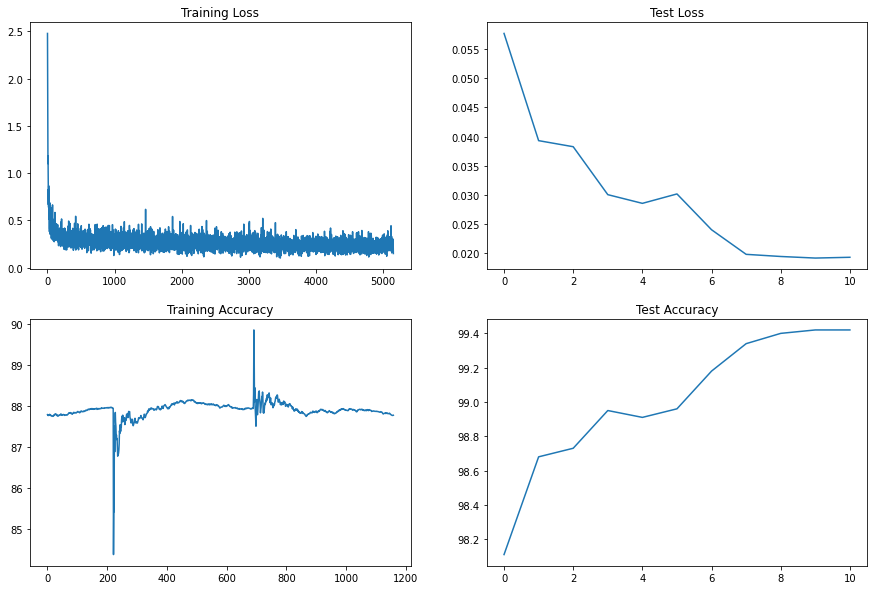

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
import numpy as np
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [ ]:
correct = []
wrong = []
for i in range (20):
  images, labels = next (iter (test_loader))

  img = images
  # Turn off gradients to speed up this part
  with torch.no_grad():
      logps = model (img.cuda())

  # Output of the network are log-probabilities, need to take exponential for probabilities
  ps = torch.exp (logps)
  probabs = []
  for j, element in enumerate (ps):
      pred = torch.argmax(element)
      if pred == labels[j].item ():
          correct.append ([img[j], ps[j], pred, labels[j].item ()])
      else:
          wrong.append ([img[j], ps[j], pred, labels[j].item ()])

len (correct), len (wrong)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(2543, 17)

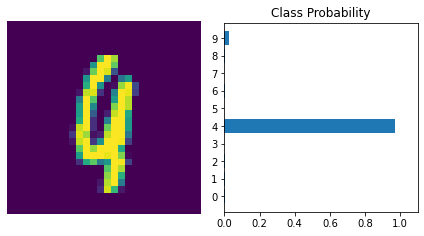

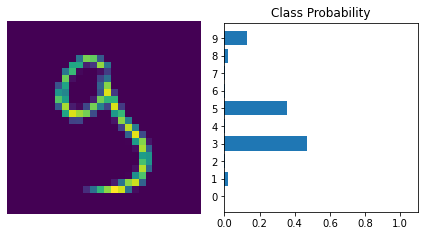

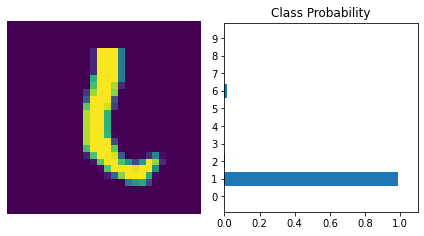

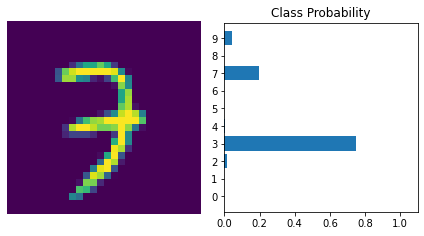

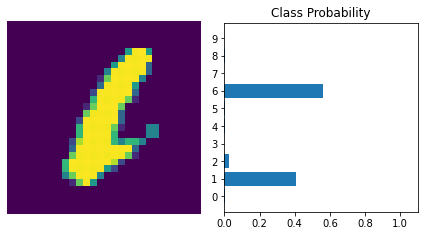

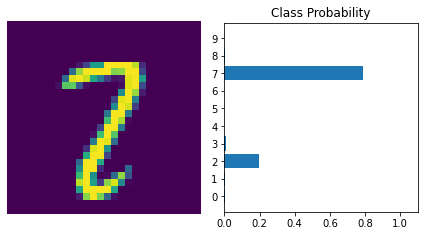

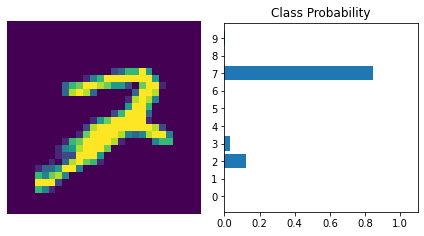

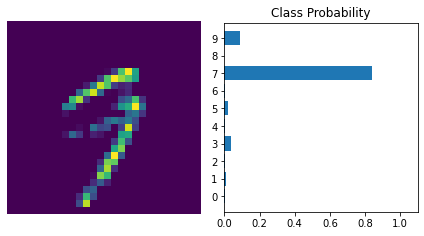

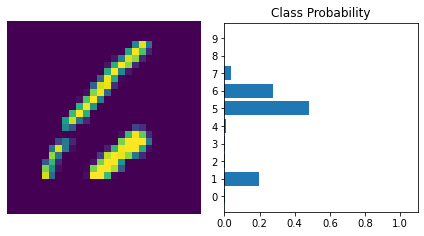

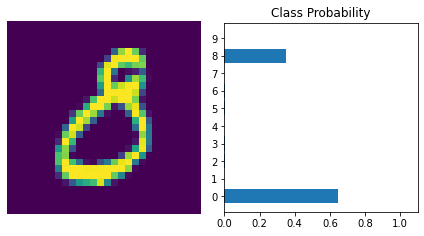

In [ ]:
for i in range (10):
  view_classify (wrong[i][0], wrong[i][1])

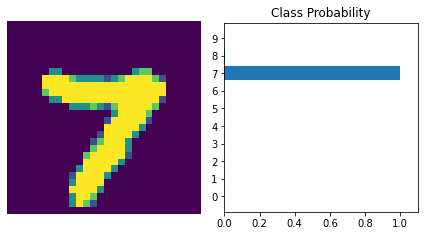

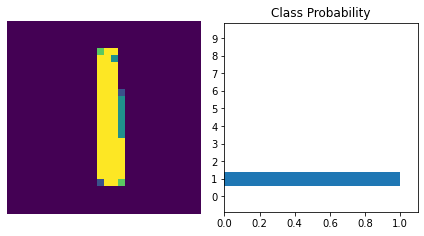

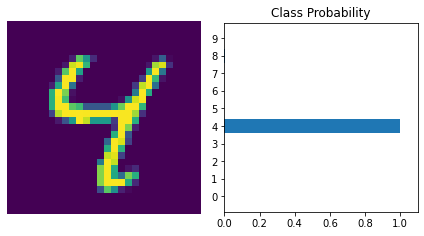

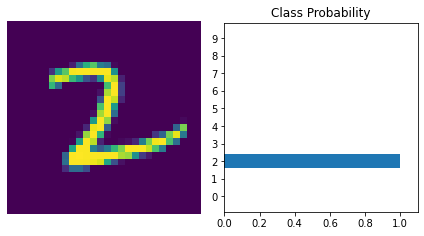

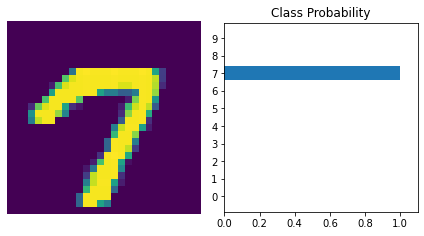

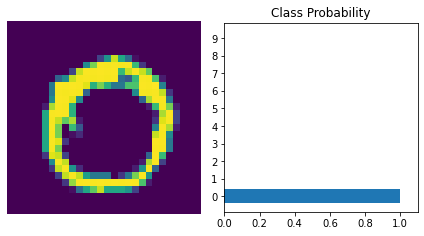

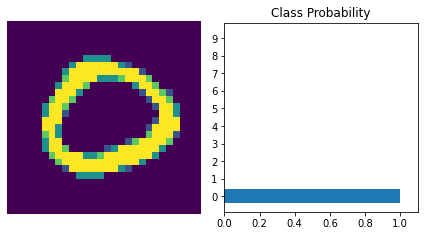

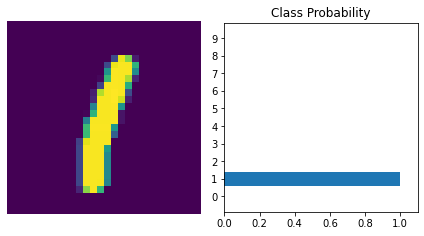

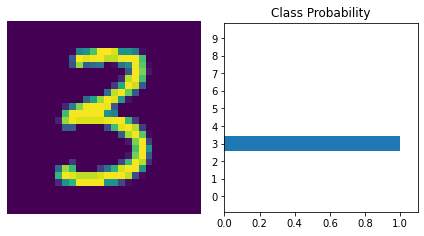

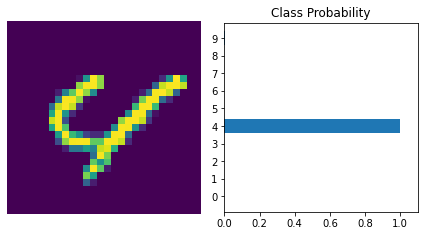

In [ ]:
for i in range (10):
  view_classify (correct[i][0], correct[i][1])